In [22]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = sns.load_dataset("flights")
print(data.head())
print(data.shape)


   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121
(144, 3)


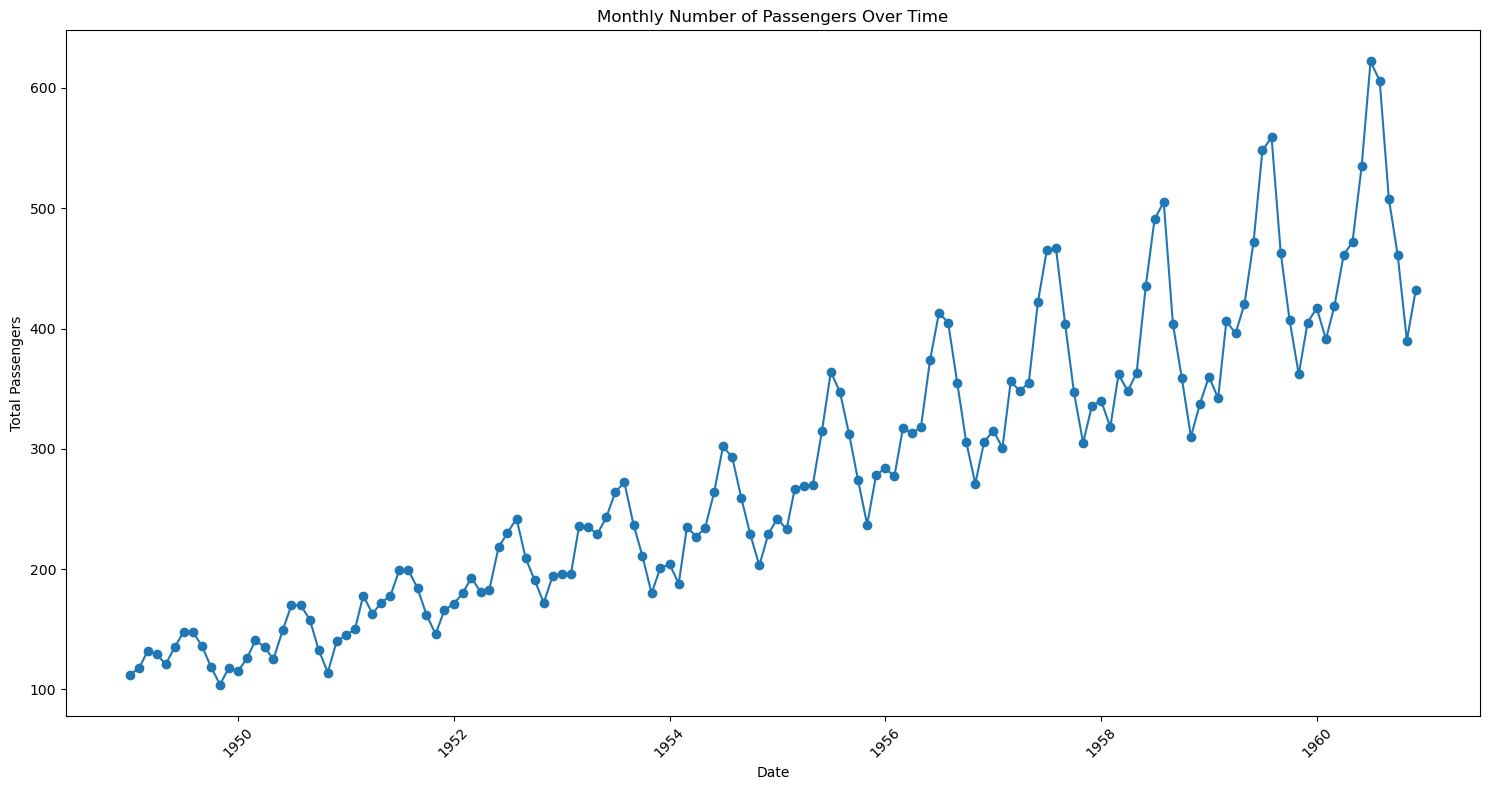

In [25]:
# Check and clean data types
data['year'] = data['year'].astype(str)  # Convert year to string
data['month'] = data['month'].astype(str)  # Ensure month is string

# Ensure month column is in the correct format
valid_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data['month'] = pd.Categorical(data['month'], categories=valid_months, ordered=True)

# Create a datetime column by combining year and month
data['date'] = pd.to_datetime(data['year'] + '-' + data['month'].astype(str), format='%Y-%b')

# Sort the data by the new datetime column
data = data.sort_values('date')

# Plot the data
plt.figure(figsize=(15, 8))
plt.plot(data['date'], data['passengers'], marker='o', linestyle='-')

# Set plot labels and title
plt.title('Monthly Number of Passengers Over Time')
plt.ylabel('Total Passengers')
plt.xlabel('Date')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [27]:
print(data.columns)
all_data = data['passengers'].values.astype(float)
print(all_data)

test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))
print("test_data ", test_data)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Initialize the scaler to normalize data to the range [-1, 1]
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
print("train_data_normalized[:5]", train_data_normalized[:5])  # Print the first 5 normalized training data values
print("train_data_normalized[-5:]", train_data_normalized[-5:])

Index(['year', 'month', 'passengers', 'date'], dtype='object')
[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]
132
12
test_data  [417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]
train_data_normalized[:5] [[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
train_data_normalized[-

In [30]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)  # Convert normalized training data to a PyTorch tensor and flatten it
train_window = 12  #size of the historical context that the model will use to make predictions.

def create_inout_sequences(input_data, tw):  # generate input-output pairs from time series data for training a model
#  tw: size of the sliding window for creating input-output sequences
    inout_seq = [] 
    L = len(input_data) 
    for i in range(L-tw):  
        train_seq = input_data[i:i+tw] 
        train_label = input_data[i+tw:i+tw+1]  # Define the label as the next value after the sequence
        inout_seq.append((train_seq, train_label))  # Append the sequence and label as a tuple to the list
    return inout_seq  

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
print(train_inout_seq[:5])  


[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])), (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
        -0.9341, -1.0000, -0.9385, -0.9516]), tensor([-0.9033])), (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
        -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])), (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
        -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])), (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
        -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]


In [31]:
class LSTM(nn.Module):  
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1): 
        super().__init__() 
        self.hidden_layer_size = hidden_layer_size  #  number of hidden units (neurons) in each LSTM layer

        self.lstm = nn.LSTM(input_size, hidden_layer_size)  # Define the LSTM layer

        # The LSTM layer produces a sequence of hidden states, one for each time step in the input sequence.
        # Each hidden state has a dimensionality equal to hidden_layer_size.
        # Define a linear layer to map the LSTM output to the desired output size
        self.linear = nn.Linear(hidden_layer_size, output_size)  

        # LSTM networks maintain two states throughout their operation: the hidden state (h) and the cell state (c), used to carry information across time steps
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),  # Initialize hidden state with zeros
                            torch.zeros(1,1,self.hidden_layer_size))  # Initialize cell state with zeros

    def forward(self, input_seq):  # Define the forward pass of the network
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)  # input should be in the dimenstions of (sequence_length, batch_size, input_size)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))  # Pass the LSTM output through the linear layer to get predictions
        return predictions[-1]  # Return the last prediction (for the final time step)

model = LSTM()  # Instantiate the LSTM model
loss_function = nn.MSELoss()  # Define the loss function as Mean Squared Error Loss, suitable for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Define the optimizer as Adam with a learning rate of 0.001
print(model)  # Print the model architecture to check the layers and parameters


LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [33]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()  # Clear the previous gradients to avoid accumulation
        # Reinitialize hidden and cell states for the LSTM for each new sequence
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq) # forward pass through the model to get predictions

        single_loss = loss_function(y_pred, labels) # loss between predictions and actual labels
        single_loss.backward() # gradient of the loss with respect to model parameters
        optimizer.step()  # Update the model parameters using the computed gradients

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.00054089
epoch:  26 loss: 0.00711940
epoch:  51 loss: 0.00099398
epoch:  76 loss: 0.00055160
epoch: 101 loss: 0.00000162
epoch: 126 loss: 0.00001919
epoch: 149 loss: 0.0002302449


In [34]:
fut_pred = 12  # Number of future time steps to predict

test_inputs = train_data_normalized[-train_window:].tolist() # Initialize the test inputs with the last `train_window` values from the training data

print(test_inputs)
model.eval()  # Set the model to evaluation mode to disable dropout and batch normalization

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])  # Convert the last `train_window` values to a FloatTensor
    with torch.no_grad():       # Perform prediction without updating gradients (no backpropagation)
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())   #  model(seq).item(): model's prediction

print(test_inputs[fut_pred:])
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1)) # Inverse transform the normalized predictions to the original scale

print(actual_predictions)

x = np.arange(132, 144, 1)
print(x)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]
[0.4921902120113373, 0.5254507064819336, 0.6156064867973328, 0.7848459482192993, 1.015383005142212, 1.2546921968460083, 1.467074990272522, 1.6000821590423584, 1.5892548561096191, 1.483481764793396, 1.4261062145233154, 1.4111158847808838]
[[443.47327323]
 [451.04003572]
 [471.55047575]
 [510.05245322]
 [562.49963367]
 [616.94247478]
 [665.25956029]
 [695.51869118]
 [693.05547976]
 [668.99210149]
 [655.9391638 ]
 [652.52886379]]
[132 133 134 135 136 137 138 139 140 141 142 143]


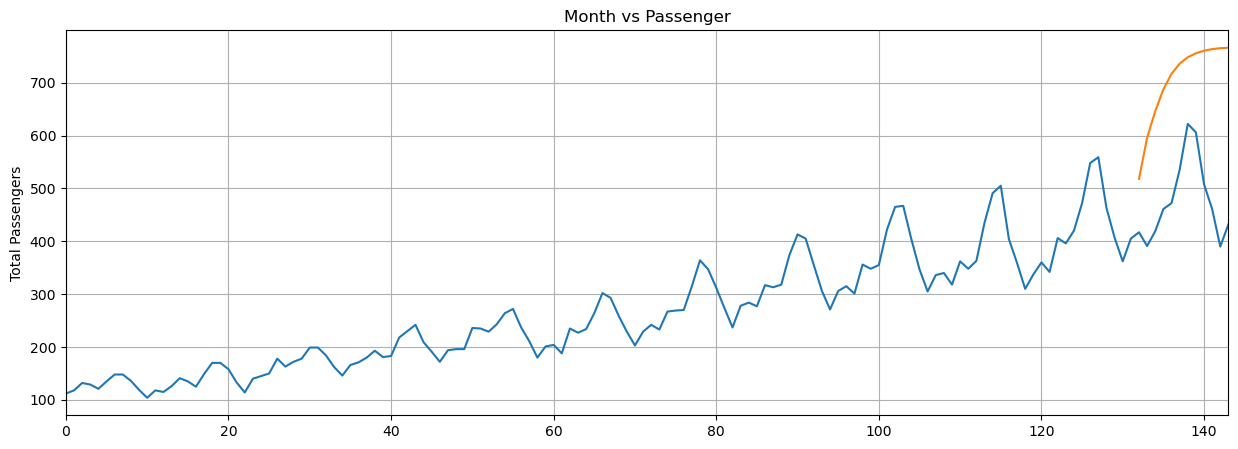

In [14]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['passengers'])
plt.plot(x,actual_predictions)
plt.show()


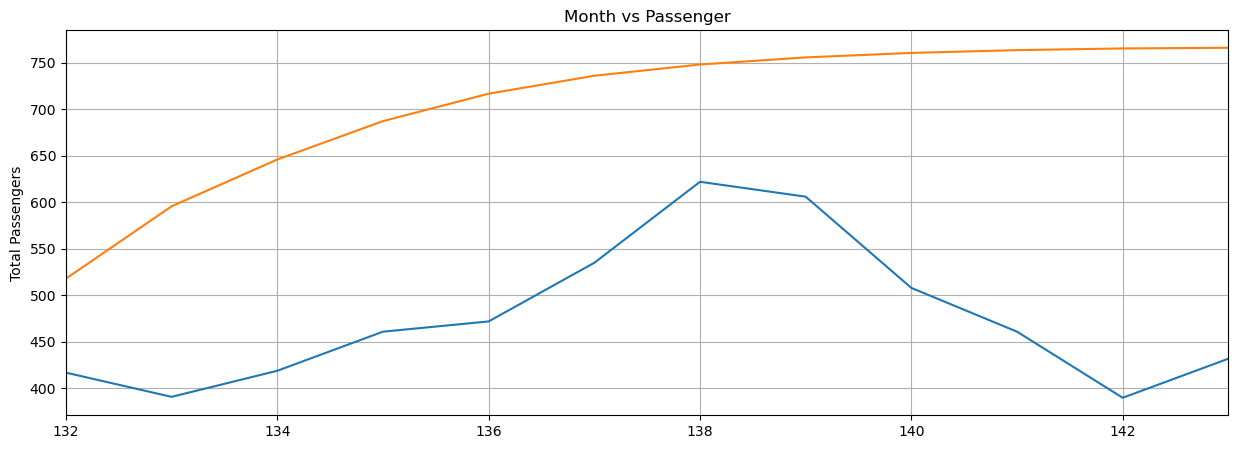

In [15]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()